Checklist
1. Make sure your "Regional Format" is set to "English (United Kingdom)" before Excel opens files that contain English date-like objects,
   if you want them to be parsed as English datetime. English (United States) regional format will convert them to American Datetime as possible.
   You have no way to prevent Excel from converting date-like strings or objects to datetime when opening a file. 

In [1]:
import random
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
# import pandas as ps
import time
import datetime
import re
import os
import shutil
import glob
import math

from config import config
import data_helpers

In [2]:
TEST_ID = 'X.06'
BASE_TEST_ID = ''  # should be either '' or an existing TEST_ID.
DATA_BITS = 32              #------------------ 16 doesn't work.
STARTING_PERCENT = 0
ENDING_PERCENT = 6          # 0 -> 6
TRAIN_PERCENT= 94
VALID_PERCENT = 3
TEST_PERCENT = 100 - TRAIN_PERCENT - VALID_PERCENT
BUFFER_SIZE = 35000
BATCH_SIZE = 4  #-----------------------------------
DIM_TRANSFORMER = 190   # Experimental. Check it.
LEARNING_RATE = 2e-7 # 1e-6 : [:44] # 1e-6 if BASE_TEST_ID == ''. 
TEAM_EMBS = 50  #
DROPOUT = 0.0               # 0.1 -> 0.0
TRANSFORMER_LAYERS = 6
TRANSFORMER_HEADS = 60
ADAPTORS_LAYERS = 10
RESET_HISTORY = False
MIN_PROFIT = -1.0
PROFIT_KEYS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [3]:
COUNTRY = 'England'
NUMBER_BOOKIES = 3  # Take William Hills, Bet&Win, and Bet365. Other bookies' odds list change over years and leagues.
DIVIISONS = ['E0', 'E1', 'E2', 'E3']    # 'EC', the Conference league, is excluded as some odds are not archived for the league since 2013.

#-------------------- England ---------------------
# Time range of data: 2004/2005 - 2024/2025
# Leagues - Premiere, League 1, League 2, Championship, Conference
# !!! Conference will be omitted because they lack Shoot_cols and ShootT_cols since 2026. Those columns are important.
# Bookies - Bookie1 : WH(William Hills), Bookie2: BW(Bet&Win), Bookie3 : B365(Bet365), Bookie4 : Mixed
# William Hills, Bet365 on Premier: https://www.oddschecker.com/football/english/premier-league
# William Hills, Bet365 on Championship: https://www.oddschecker.com/football/english/championship
# William Hills, Bet365 on League-1: https://www.oddschecker.com/football/english/league-1
# William Hills, Bet365 on League-2: https://www.oddschecker.com/football/english/league-2
# William Hills, Bet365 on Conference: https://www.oddschecker.com/football/english/non-league/national-league
# BWin(Bet&Win) on Premier and Chanpionship: https://sports.bwin.fr/fr/sports/football-4/paris-sportifs/angleterre-14

# COUNTRY = 'Scotland'
# NUMBER_BOOKIES = 3  # Take ...

In [4]:
ODDS_COLS = []
for b in range(NUMBER_BOOKIES):
    ODDS_COLS += ['HDA'+str(b)+'H', 'HDA'+str(b)+'D', 'HDA'+str(b)+'A']

In [5]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ODDS_COLS
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Result_cols = ['HTR', 'FTR']    # A function of Goal_cols, but contribute to better representation.
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
Red_cols = ['HR', 'AR']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Half_Goal_cols + Full_Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols
Required_Non_Odds_cols = Div_cols + Date_cols + Team_cols + Half_Goal_cols + Full_Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

# underscore_prefixed lists have discontinued columns.
BBAB_cols = BB_cols + AB_cols
_Cols_List_to_Embbed = [Div_cols, Team_cols, Half_Goal_cols, Full_Goal_cols, Result_cols, Shoot_cols, ShootT_cols, Corner_cols, Faul_cols, Yellow_cols, Red_cols]
_Cols_List_to_Unembbed = [Odds_cols]
_Cols_List_to_Standardize = [Odds_cols, Shoot_cols, ShootT_cols, Corner_cols, Faul_cols, Yellow_cols, Red_cols]
_Cols_List_for_Label = [Full_Goal_cols, Odds_cols]
_Label_cols = Full_Goal_cols + Odds_cols


In [6]:
print(BBAB_cols)
print(BB_cols)
print(_Label_cols)

['id', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A', 'HDA2H', 'HDA2D', 'HDA2A', 'HTHG', 'HTAG', 'FTHG', 'FTAG', 'HTR', 'FTR', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']
['id', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A', 'HDA2H', 'HDA2D', 'HDA2A']
['FTHG', 'FTAG', 'HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A', 'HDA2H', 'HDA2D', 'HDA2A']


In [7]:
_Cols_List_to_Standardize

[['HDA0H',
  'HDA0D',
  'HDA0A',
  'HDA1H',
  'HDA1D',
  'HDA1A',
  'HDA2H',
  'HDA2D',
  'HDA2A'],
 ['HS', 'AS'],
 ['HST', 'AST'],
 ['HC', 'AC'],
 ['HF', 'AF'],
 ['HY', 'AY'],
 ['HR', 'AR']]

In [8]:
def get_std_size():
    size = 0
    for cols in _Cols_List_to_Standardize:
        size += len(cols)
    return size

def get_standardization_params(df_grown):
    
    def get_mean_and_std(cols):
        array = df_grown[cols]
        array = np.array(array)
        return (array.mean(), array.std(), np.max(array))
    
    params = {}
    for cols in _Cols_List_to_Standardize:
        params[cols[0]] = get_mean_and_std(cols)

    return params


def check_standardization(bbab, std_params):
    for cols in _Cols_List_to_Standardize:
        start = BBAB_cols.index(cols[0]); end = start + len(cols)
        (mean, std, maximum) = std_params[cols[0]]
        if -mean/std > min(bbab[start : end]) + 1e-5:
            print('standardization error 1', cols[0], -mean/std, bbab[start : end])
        if max(bbab[start : end]) > (maximum - mean) / std + 1e-5:
            print('standardization error 2', cols[0], bbab[start : end], (maximum - mean) / std)

In [9]:
seed = 32
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [10]:
countryDirPath = "./data/football-data-co-uk/" + COUNTRY
data_helpers.assign_seasonal_filenames(countryDirPath)
df_grown, df_extra = data_helpers.get_grown_extra_from_football_data_co_uk(countryDirPath, Required_Non_Odds_cols, NUMBER_BOOKIES, skip=True)
print(df_grown.shape[0], df_extra.shape[0])

files found to rename:  0
total rows in renamed files:  0
41094 0


In [11]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

def createSimpleTokenizer(corpus_files, vocab_size, unknown_token, special_tokens):
        tokenizer = Tokenizer(models.WordLevel(unk_token=unknown_token))
        tokenizer.normalizer = normalizers.Sequence([normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()])
        tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()
        trainer = trainers.WordLevelTrainer(vocab_size=vocab_size, special_tokens=special_tokens)
        tokenizer.train(corpus_files, trainer=trainer)
        tokenizer.decoder = decoders.WordPiece(prefix=" ")
        return tokenizer

def creat_team_tokenizer_uk(df_grown):
    teams = list(set(list(df_grown['HomeTeam']) + list(df_grown['AwayTeam'])))
    teams_string = [str(team) for team in teams]
    teams_string = [re.sub(r"\s", "_", item) for item in teams_string]    # replace spaces with a '_'
    teams_text = " ".join(teams_string)

    corpus_file = os.path.join(countryDirPath, '_tokenizers', 'team_ids_text_uk.txt')
    f = open(corpus_file, "w+", encoding="utf-8")
    f.write(teams_text)
    f.close()

    corpus_files = [corpus_file]
    unknown_token = config['unknown_token']
    special_tokens = [unknown_token] ################### + ["[HOME]", "[AWAY]"]
    vocab_size = len(teams_string) + len(special_tokens)

    tokenizer_team = createSimpleTokenizer(corpus_files, vocab_size, unknown_token, special_tokens)
    return tokenizer_team

In [12]:
tokenizer_team = creat_team_tokenizer_uk(df_grown)
print(tokenizer_team.get_vocab_size())

teams = ['Tottenham', 'Arsenal', 'Liverpool', 'what?', 'Tottenham', 'Chelsea', 'e_t', 'Man United', '1234', '[HOME]', '[AWAY]']
teams = [team.strip() for team in [re.sub(r"\s", "_", item) for item in teams]]
teams = " ".join(teams)
encoding = tokenizer_team.encode(teams)
# encoding = tokenizer.encode("")
print(encoding.tokens)
print(encoding.type_ids)
print(encoding.ids)

tokenizer_team.decode(encoding.ids)

114
['tottenham', 'arsenal', 'liverpool', '[UNK]', 'tottenham', 'chelsea', '[UNK]', 'man_united', '[UNK]', '[UNK]', '[UNK]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[102, 4, 59, 0, 102, 28, 0, 63, 0, 0, 0]


'tottenham arsenal liverpool tottenham chelsea man_united'

In [13]:
#================= build_id_to_ids.ipynb

QUALITY = 75

targetLength = 300          # A target game will be explained by maximum 'targetLength' count of past games.
minCurrent = 1e-7
sinceDaysAgo = 365 * 20     # A target game will be explained by past games that took place since 'sinceDaysAgo' days ago. 
qualityPct = QUALITY        #
conductance365 = 0.9        # 0.9 comes from test.
chooseDivs=False

id_to_ids = data_helpers.fixture_id_to_ids_uk_maxflow(countryDirPath, targetLength, minCurrent, sinceDaysAgo, qualityPct, conductance365, df_grown, chooseDivs=chooseDivs)

id_to_ids_filename = str(targetLength) + '-' + str(minCurrent) + '-' + str(sinceDaysAgo) + '-' + str(qualityPct) + '-' + str(conductance365) + '-' + str(chooseDivs) + '.json'
id_to_ids_filePath = os.path.join(countryDirPath, '_id_to_ids', id_to_ids_filename)
data_helpers.SaveJsonData(id_to_ids, id_to_ids_filePath)

print(len(id_to_ids))

41094


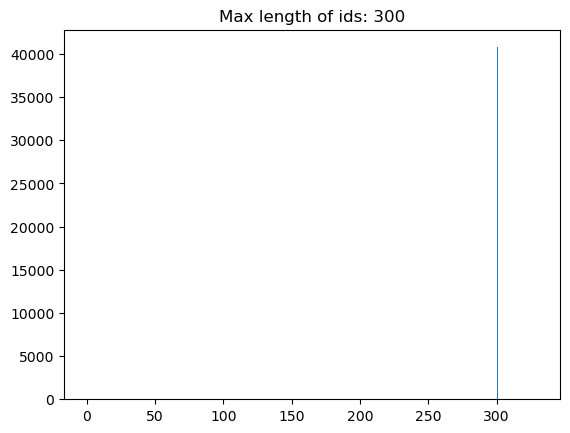

In [14]:
lengths = [len(ids) for (tag, label, ids) in id_to_ids.values()]
maxLen = max(lengths)
plt.hist(lengths, np.linspace(0, int(maxLen*1.1), int(maxLen*1.1) + 1))
plt.ylim(plt.ylim())
maxLen = max(lengths)
# plt.plot([maxLen, maxLen], plt.ylim())
plt.title(f'Max length of ids: {maxLen}')

lengths = [len(ids) for (tag, label, ids) in id_to_ids.values()]
maxLen = max(lengths)
plt.hist(lengths, np.linspace(0, int(maxLen*0.9), int(maxLen*0.9) + 1))
plt.ylim(plt.ylim())
maxLen = max(lengths)
# plt.plot([maxLen, maxLen], plt.ylim())
plt.title(f'Max length of ids: {maxLen}')

MAX_TOKENS = maxLen

In [15]:
# base_bbab = list(df_grown.loc[df_grown['id'] == min(df_grown['id']), BBAB_cols].iloc[0, :])
# print(base_bbab)

def normalize_raw_bbab(bbab, tokenizer_team, std_params):

    """
        BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols
        AB_cols = Half_Goal_cols + Full_Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

        This is how the data returned by this function is consumed. Note this function doesn't alter the order of columns.
       
        if self.isEncoder:
            # Extract odds to remove them
            id, div, days, teams, odds, half_goals, full_goals, result, remainder \
            = tf.split(sequence, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), len(Half_Goal_cols), len(Full_Goal_cols), len(Result_cols), -1], axis=-1)
            # All shape of (batch, sequence, own_columns)
        else:
            # Extract odds to remove them
            id, div, days, teams, odds, remainder \
            = tf.split(base_bb, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), -1], axis=-1)  
    """

    #---------------------- label, before changing bbab
    label = []
    for cols in _Cols_List_for_Label:
        start = BBAB_cols.index(cols[0]); end = BBAB_cols.index(cols[-1]) + 1
        label += bbab[start : end]

    #----------------------- columns to embed: Div, HomeTeam, AwayTeam, HTHG, HTAG, FTHG, FTAG, HTR, FTR
    start = BBAB_cols.index(Div_cols[0])
    Div = bbab[start]
    bbab[start] = DIVIISONS.index(Div)  # Assumes no n/a

    start = BBAB_cols.index(Team_cols[0]); end = BBAB_cols.index(Team_cols[-1]) + 1
    pair_str = [str(team) for team in bbab[start : end]]    # Team names are already normalized, removing/striping spaces.
    pair_text = " ".join(pair_str)
    pair_tokens = tokenizer_team.encode(pair_text).ids
    bbab[start : end] = pair_tokens # 0 for Unknown, by tokenizer trainig.

    start = BBAB_cols.index(Goal_cols[0]); end = BBAB_cols.index(Goal_cols[-1]) + 1
    bbab[start: end] = bbab[start : end]   # Goals themselves are good tokens, assuming there is no Unknown. mask_zero = False
    
    start = BBAB_cols.index(Result_cols[0]); end = BBAB_cols.index(Result_cols[-1]) + 1
    bbab[start : end] = [ ['H', 'D', 'A'].index(result) for result in bbab[start : end]]    # Assumes no n/a

    #--------------------- standardize
    for cols in _Cols_List_to_Standardize:
        start = BBAB_cols.index(cols[0]); end = BBAB_cols.index(cols[-1]) + 1
        (mean, std, maximum) = std_params[cols[0]]
        assert 0 <= min(bbab[start : end])
        bbab[start : end] = [ (item - mean) / std for item in bbab[start : end] ]
        assert - mean/std <= min(bbab[start : end])
        assert max(bbab[start : end]) <= (maximum - mean) / std
        # print('std', bbab[start : end])

    #--------------------- columns for positional embedding
    start = BBAB_cols.index(Date_cols[0])
    date = bbab[start]
    bbab[start] = (datetime.datetime.combine(date, datetime.time(0,0,0)) - config['baseDate']).days  # either positive or negative

    #---------------------- bb only
    start = BBAB_cols.index(BB_cols[0]); end = start + len(BB_cols)
    bb = bbab[start : end]

    #----------------------- return
    """
    Div, Team, and Result are digitalized.
    Date is converted to days since config['baseDate'])

    bbab follows BBAB. list
    bb follows BB. list
    label follows fused _Cols_List_for_Label. list
    date: single field
    """
    return bbab, bb, label, date

def getDateDetails(date):
    baseYear = config['baseDate'].year
    date_details = tf.Variable([date.year - baseYear, date.month, date.day, date.weekday()], dtype=tf.int32)
    return date_details     # (4,)

def get_data_record(df_grown, baseId, ids, tokenizer_team, std_params):
    # try:
        # base_bbab = list(df_grown.loc[df_grown['id'] == baseId, BBAB_cols])
        base_bbab = list(df_grown[df_grown['id'] == baseId][BBAB_cols].iloc[0, :])  # base_bbab follows BBAB. list
        base_bbab, base_bb, base_label, base_date = normalize_raw_bbab(base_bbab, tokenizer_team, std_params)
        # print('2', base_bbab)
        baseId = tf.Variable(baseId, dtype=tf.int32)
        base_bbab = tf.Variable(base_bbab, dtype=tf.float32)    # (len(BBAB_cols),)
        base_bb = tf.Variable(base_bb, dtype=tf.float32)        # (len(BB_cols),)
        base_label = tf.Variable(base_label, dtype=tf.float32)  # (len(_Label_cols),)
        # print('3', base_bbab)
        # Default sequence.
        sequence = tf.transpose(tf.Variable([[]] * len(BBAB_cols), dtype=tf.float32))   # (0, len(BBAB_cols))
        # sequence = np.array([[]] * len(BBAB_cols), dtype=config['np_float']).T
        # print('3.5', sequence)
        baseDateDetails = getDateDetails(base_date) # (4,)

        concat = []
        for id in ids:
            bbab = list(df_grown[df_grown['id'] == id][BBAB_cols].iloc[0, :])   # bbab follows BBAB. list
            # print('4', bbab)
            bbab, _, _, _ = normalize_raw_bbab(bbab, tokenizer_team, std_params)   # bbab follows BBAB. list
            # check_standardization(bbab, std_params)

            bbab = tf.Variable(bbab, dtype=tf.float32)[tf.newaxis, :]       # (1, len(BBAB_cols))
            # _bbab = bbab[0].numpy()
            # check_standardization(_bbab, std_params)

            concat.append(bbab)     # concat doesn't create a new axis.

        if len(concat) > 0:
            sequence = tf.concat(concat, axis=0)    # (nSequence, len(BBAB_cols))
            # if sequence.shape[0] > 0:
            #     bbab = sequence[0].numpy()
            #     check_standardization(bbab, std_params)

        # print('6', sequence)
        """
        baseId: (). tf.int32
        base_bbab follows BBAB. (len(BBAB_cols),). tf.float32
        sequence[i, :] follows BBAB. (nSequence, len(BBAB_cols)). tf.float32
        base_bb follows BB. (len(BB_cols),). tf.float32
        base_label follows _Cols_List_for_Label. (len(_Label_cols),). tf.float32
        baseDateDetails: tensor (yy, m, d, wd)
        """
        return (baseId, base_bbab, sequence, base_bb, base_label, baseDateDetails)
    # except:
    #     raise Exception("Failed to get_BBAB for baseId = {}".format(baseId))   

def generate_dataset_uk(df_grown, fixture_id_to_ids, tokenizer_team, std_params):       
    def generator():
        count = 0
        for baseId, (tag, label, ids) in fixture_id_to_ids.items():
            baseId = int(baseId)
            # print('0', baseId, ids)
            (baseId, _, sequence, base_bb, base_label, baseDateDetails) = get_data_record(df_grown, baseId, ids, tokenizer_team, std_params)
            print("count: {}, baseId: {}".format(count, baseId), end='\r'); count += 1
            
            # if count > 500: break

            #--------------------- verify
            # if sequence.shape[0] > 0:
            #     bbab = sequence[0, :].numpy()
            #     # print('11', bbab)
            #     for cols in _Cols_List_to_Standardize:
            #         start = BBAB_cols.index(cols[0]); end = start + len(cols)
            #         # print('.0', cols[0], start, end)
            #         (mean, std, maximum) = std_params[cols[0]]
            #         # print('.0.1', cols[0], mean, std, maximum)

            #         # if -mean/std > min(bbab[start : end]) + 1e-5:
            #         #     print('.1', cols[0], -mean/std, bbab[start : end])
            #         # if max(bbab[start : end]) > (maximum - mean) / std + 1e-5:
            #         #     print('.2', cols[0], bbab[start : end], (maximum - mean) / std)

            yield (baseId, sequence, base_bb, base_label, baseDateDetails)

    ds = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.int32, tf.float32, tf.float32, tf.float32, tf.int32),
        output_shapes=(tf.TensorShape(()), tf.TensorShape((None, len(BBAB_cols))), tf.TensorShape((len(BB_cols),)), tf.TensorShape((len(_Label_cols),)), tf.TensorShape((4,))),
        args=()
    )
    return ds

def get_patch_bbab_tensor_uk(df_grown, tokenizer_team, std_params):
    # The first games bbab will be used as a patch bbab.
    (baseId, base_bbab, sequence, base_bb, base_label, baseDateDetails) = get_data_record(df_grown, min(list(df_grown['id'])), [], tokenizer_team, std_params)
    patch_bbab = tf.zeros_like(base_bbab, dtype=tf.float32) # All embedding fields will be zero, which means Unknown for all but goal fields.
    return patch_bbab



In [16]:
class hParams:    
    nDivisions = len(DIVIISONS)
    division_embs = 4
    nTeams = tokenizer_team.get_vocab_size()    # including Unknown
    team_embs = TEAM_EMBS
    nGoals  = 6  # 0 for 0 goals not for Unknown. Maximum nGoals goals for a team in each of 1st and 2nd halfs. Extra goals will be clipped_by_value.
    combi_goal_embs = 8
    nresult = 4    # HWin, Draw, AWin, and Unknown
    result_embs = 4
    shoot_embs = 2
    shootT_embs = 2
    corner_embs = 2
    faul_embs = 2
    yellow_embs = 2
    red_embs = 2
    d_model = DIM_TRANSFORMER
    batch_size = BATCH_SIZE
    days_spanning_years = 30
    num_layers = TRANSFORMER_LAYERS
    num_heads = TRANSFORMER_HEADS
    m365_size = 1
    initial_m365 = 0.9
    # d_model = team_emb_size * 2 + country_emb_size * 3 + odds_size + outcome_size

In [17]:
print(get_std_size())

21


In [18]:
std_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-normal' + ".json")
std_params = get_standardization_params(df_grown)
print(std_params)
data_helpers.SaveJsonData(std_params, std_path)
std_params = data_helpers.LoadJsonData(std_path)

{'HDA0H': (3.210573865879312, 1.5258159740665058, 46.0), 'HS': (11.441378303401956, 4.735880157749907, 43.0), 'HST': (4.782486494378741, 2.7453410076905613, 24.0), 'HC': (5.334087701367596, 2.8459169771091317, 24.0), 'HF': (11.418832432958583, 3.7520091325566027, 77.0), 'HY': (1.568513651627975, 1.2447348578129853, 11.0), 'HR': (0.07892879739134667, 0.28335735667479767, 3.0)}


In [19]:
ds_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-dataset')

if os.path.exists(ds_path):
    ds = tf.data.Dataset.load(ds_path)
else:
    ds = generate_dataset_uk(df_grown, id_to_ids, tokenizer_team, std_params)
    tf.data.Dataset.save(ds, ds_path)
    ds = tf.data.Dataset.load(ds_path)      # Wierd, this line is required. len(ds) would have no value!!!

len(ds)

41094

In [20]:
total_size = len(ds)

starting_size = int(STARTING_PERCENT/100 * total_size)
ending_size = int(ENDING_PERCENT/100 * total_size)
take_size = total_size - starting_size - ending_size
remaining_ds = ds.skip(starting_size)
dataset = remaining_ds.take(take_size)

dataset_size = len(dataset)

train_size = int(TRAIN_PERCENT/100 * dataset_size)
valid_size = int(VALID_PERCENT/100 * dataset_size)
test_size = dataset_size - train_size - valid_size

_train_ds = dataset.take(train_size)                # [: train_size]
remaining_ds = dataset.skip(train_size - valid_size)     # [train_size - valid_size: ]

_back_ds = remaining_ds.take(valid_size)            # [train_size - valid_size, train_size]
remaining_ds = remaining_ds.skip(valid_size)        # [train_size: ]

_valid_ds = remaining_ds.take(valid_size)            # [train_size, train_size + valid_size]
_test_ds = remaining_ds.skip(valid_size)             # [train_size + valid_size :]

assert len(_test_ds) == test_size

assert dataset_size == len(_train_ds) + len(_valid_ds) + len(_test_ds)

print(total_size, len(dataset), len(_train_ds), len(_back_ds), len(_valid_ds), len(_test_ds))

41094 38629 36311 1158 1158 1160


In [21]:
patch_bbab_tensor = get_patch_bbab_tensor_uk(df_grown, tokenizer_team, std_params)

In [22]:
def normalize_row(baseId, sequence, base_bb, base_label, baseDateDetails):
    """
    # return from get_data_record(.)
    baseId: (). tf.int32
    base_bbab follows BBAB. (len(BBAB_cols),). tf.float32
    sequence[i, :] follows BBAB. (nSequence, len(BBAB_cols)). tf.float32
    base_bb follows BB. (len(BB_cols),). tf.float32
    base_label follows _Cols_List_for_Label. (len(_Label_cols),). tf.float32
    baseDateDetails: tensor (yy, m, d, wd)

    # call from normalize_dataset(.)
    inp=[baseId, sequence, base_bb, base_label],
    Tout=[tf.int32, tf.float32, tf.float32, tf.float32, tf.int32, tf.int32])) #, tf.data.AUTOTUNE == Instability!!!
    """

    try:
        seq_len_org = sequence.shape[0]
        nMissings = MAX_TOKENS - seq_len_org
        if nMissings > 0:
            # patch_bbab_tensor has the same type as base_bbab, or as sequence[i, :]
            patch = tf.stack([patch_bbab_tensor] * nMissings, axis=0)
            sequence = tf.concat([sequence, patch], axis=0)     # concat doesn't create a new axis. (MAX_TOKENS, len(BBAB_cols))
        # print("sequence 1", sequence.shape)
        # sequence[:, 2] = base[2] - sequence[:, 2]   # get delta days.
        base_bb = base_bb[tf.newaxis, :]    # shape: (seq_len = 1, len(BBAB_cols))
        baseDateDetails = baseDateDetails[tf.newaxis, :]
        mask = tf.Variable([1] * seq_len_org + [0] * nMissings, dtype=tf.int32) # (MAX_TOKENS,) ## DO NOT USE tf.constant !!! unstable.
        mask = mask[:, tf.newaxis] & mask[tf.newaxis, :]    # (MAX_TOKENS, MAX_TOKENS)
        # print('normalize', sequence.shape, base.shape, mask.shape, mask)
        # seq_len_org = tf.Variable(seq_len_org, dtype=tf.int32)
        """
        baseId: (). tf.int32
        sequence: (MAX_TOKENS, len(BBAB_cols)). tf.float32
        base_bb: (seq_len = 1, len(BBAB_cols)). tf.float32
        base_label: (len(_Label_cols),). tf.float32
        mask: (MAX_TOKENS, MAX_TOKENS). tf.int32
        seq_len_org: (). tf.int64 ? tf.int32    #-------------------------------------- Check it, though tf.int32 works.
        """
        return (baseId, sequence, base_bb, base_label, baseDateDetails, mask, seq_len_org)
    except:
        print('normalize_row exception')
        print('norm 1', sequence.shape, base_bb.shape, base_label.shape, mask.shape, nMissings)
        print('norm 2', baseId, sequence, base_label, mask, nMissings)
        # return (baseId, sequence, base_bb, base_label, mask, seq_len_org)

def prepare_batch(baseId, sequence, base_bb, base_label, baseDateDetails, mask, seq_len_org):
    # target = tf.one_hot(tf.squeeze(tf.cast(base_bbab[:, :, -1], dtype=tf.int32), axis=-1), hParams.target_onehot_size)
    """
    baseId: (). tf.int32
    sequence: (MAX_TOKENS, len(BBAB_cols)). tf.float32
    base_bb: (seq_len = 1, len(BBAB_cols)). tf.float32
    base_label: (len(_Label_cols),). tf.float32
    baseDateDetails: tensor [yy, m, d, wd]
    mask: (MAX_TOKENS, MAX_TOKENS). tf.int32
    seq_len_org: (). tf.int64 ? tf.int32    #-------------------------------------- Check it, though tf.int32 works.
    """
    return (baseId, sequence, base_bb, baseDateDetails, mask), (base_label, seq_len_org)     # (X, Y)

def normalize_dataset(ds):
    return (     
        ds.map(lambda baseId, sequence, base_bb, base_label, baseDateDetails: tf.py_function(  
            func=normalize_row,
            inp=[baseId, sequence, base_bb, base_label, baseDateDetails],
            Tout=[tf.int32, tf.float32, tf.float32, tf.float32, tf.int32, tf.int32, tf.int32])) #, tf.data.AUTOTUNE == Instability!!!
        )

# I found, in PositionalEmbedding, batch size ranges between 3, 4, 6 and 8, while they should be 4 or 8, except margial rows. Check it.
train_batch_size = BATCH_SIZE
test_batch_size = BATCH_SIZE * 2

def make_train_batches(ds):
    return (
        ds
        .shuffle(BUFFER_SIZE)       # Shuffle the training dataset.
        .batch(train_batch_size)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

def make_test_batches(ds):
    return (
        ds
        .batch(test_batch_size)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

In [23]:
train_ds_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename +  '_' + str(DATA_BITS) + '_' \
        + str(starting_size) + '_' + str(len(_train_ds)) )

if os.path.exists(train_ds_path):
    train_ds = tf.data.Dataset.load(train_ds_path)
else:
    train_ds = normalize_dataset(_train_ds)
    tf.data.Dataset.save(train_ds, train_ds_path)

print(len(train_ds))

train_batches = make_train_batches(train_ds)

36311


In [24]:
cnt = 3
for z in train_batches:
    (baseId, sequence, base_bb, baseDateDetails, mask), (base_label, seq_len_org) = z
    cnt -= 1
    if cnt == 0: break
print(baseId.shape, sequence.shape, base_bb.shape, mask.shape, base_label.shape, baseDateDetails.shape, seq_len_org.shape)
sample_x = (sequence, base_bb, baseDateDetails, mask)
sample_y = (base_label, seq_len_org)

(4,) (4, 300, 32) (4, 1, 14) (4, 300, 300) (4, 11) (4, 1, 4) (4,)


In [25]:
back_ds_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename +  '_' + str(DATA_BITS) + '_' \
        + str(starting_size) + '_' + str(len(train_ds)) + '_' + str(len(_back_ds)) )
if os.path.exists(back_ds_path):
    back_ds = tf.data.Dataset.load(back_ds_path)
else:
    back_ds = normalize_dataset(_back_ds)
    tf.data.Dataset.save(back_ds, back_ds_path)

print(len(back_ds))

back_batches = make_test_batches(back_ds)

1158


In [26]:
valid_ds_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename +  '_' + str(DATA_BITS) + '_' \
        + str(starting_size) + '_' + str(len(train_ds)) + '_' + str(len(back_ds)) + '_' + str(len(_valid_ds)) )
if os.path.exists(valid_ds_path):
    valid_ds = tf.data.Dataset.load(valid_ds_path)
else:
    valid_ds = normalize_dataset(_valid_ds)
    tf.data.Dataset.save(valid_ds, valid_ds_path)

print(len(valid_ds))

valid_batches = make_test_batches(valid_ds)

1158


In [27]:
test_ds_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename +  '_' + str(DATA_BITS) + '_' \
        + str(starting_size) + '_' + str(len(train_ds)) + '_' + str(len(back_ds)) + '_' + str(len(valid_ds)) + '_' + str(len(_test_ds)))
if os.path.exists(test_ds_path):
    test_ds = tf.data.Dataset.load(test_ds_path)
else:
    test_ds = normalize_dataset(_test_ds)
    tf.data.Dataset.save(test_ds, test_ds_path)

print(len(test_ds))

test_batches = make_test_batches(test_ds)

1160


In [28]:
def positional_encoding(positions, d_model):     # positions.shape = (batch, seq_len). d_model is a positive even integer.
    # positions[b, :] = [dago_299, dago_298, ..., dago_0] = eg [6, 7, ..., 1611]

    years = 25
    quotient = 365 * years / d_model   # 325 * 25 is total days during 25 years since 2024 (the earliest data year). 
    fractional_pos = positions / quotient  # (batch, seq_len). max << d_model.  lower=0, upper<<d_model
    depth = d_model/2   #
    depths = tf.range(depth, dtype=tf.float32) / depth  # (depth,). [0/depth, 1/depth, ..., (depth-1)/depth]

    # Why do we use this specific formula for depths, while any formula will work?
    # depths will be multiplied by fractional_pos, which may have ever large number.
    # We want the product to be limited, and depths should converge to zero to limit the product.
    # If it cenverges to zero too fast, though, the generated pos_encoding will have little representative power as positional representation.
    # Why, then, do we want to limit the product?
    # The product visiting many different values will be enough for us. The solution is to let them go to zero, from a significant value.
    BIG = d_model * 1.0 * 0.8     # let it be float.
    depths = 1.0 / tf.pow(BIG, depths)        # 1 / [1, ..., BIG ** ((depth-1)/depth)] = [1, ..., >1/BIG]

    # Why fractional_pos is multiplied linearly?
    # Because (sin(A+a), cos(A+a)) is a rotation of (sin(A), cos(A)), no matter what depths is.
    angle_rads = fractional_pos[:, :, tf.newaxis] * depths  # [0, ..., <<d_model ] * [ 1, ..., >1/BIG]. 
    # Interleaving sin and cos is equivalent to seperated sin and cos.
    # pos_encoding = rearrange([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], 'w b p d -> w h (w t)')  # Interleaving sin and cos. (batch, seq_len, d_model)
    pos_encoding = tf.concat([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], axis=-1)   # Seperated sin and cos. (batch, seq_len, d_model)
    return pos_encoding  # (batch, seq_len, d_model)

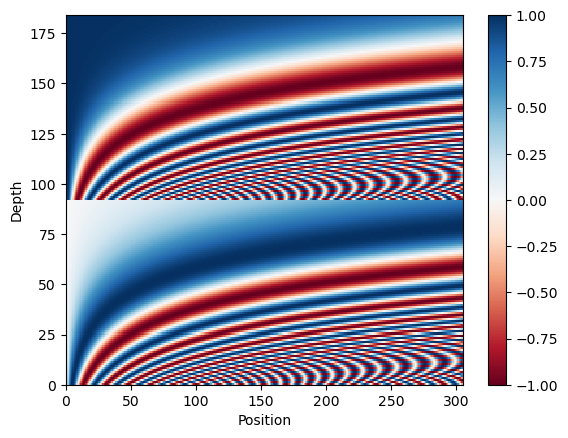

In [29]:
years = 15
seq_len = 300
d_model = 184
positions = tf.Variable([[i for i in range(0, 365 * years, int(365 * years / seq_len))] for batch in range(100)], dtype=tf.float32)
# positions = tf.ones((100, 200), dtype=tf.float32) * tf.range(200, dtype=tf.float32)
pos_encoding = positional_encoding(positions, d_model=d_model)
# print('pos_encoding', pos_encoding.shape)
pos_encoding = pos_encoding[0, :, :]
# print(pos_encoding.shape)
# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [ ]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
          base_bbab follows BBAB
          sequence[i, :] follows BBAB
          base_bb follows BB
          base_label follows _Cols_List_for_Label
          All tf.float32.
    """

    def __init__(self, hParams, isEncoder=True):
        super().__init__()
        self.isEncoder = isEncoder
        self.division_emb = tf.keras.layers.Embedding(hParams.nDivisions, hParams.division_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown
        self.team_emb = tf.keras.layers.Embedding(hParams.nTeams, hParams.team_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown
        
        self.shoot_emb = tf.keras.layers.Embedding(len(Shoot_cols), hParams.shoot_embs, dtype=tf.float32, mask_zero=False)
        self.shootT_emb = tf.keras.layers.Embedding(len(ShootT_cols), hParams.shootT_embs, dtype=tf.float32, mask_zero=False)
        self.corner_emb = tf.keras.layers.Embedding(len(Corner_cols), hParams.corner_embs, dtype=tf.float32, mask_zero=False)
        self.faul_emb = tf.keras.layers.Embedding(len(Faul_cols), hParams.faul_embs, dtype=tf.float32, mask_zero=False)
        self.yellow_emb = tf.keras.layers.Embedding(len(Yellow_cols), hParams.yellow_embs, dtype=tf.float32, mask_zero=False)
        self.red_emb = tf.keras.layers.Embedding(len(Red_cols), hParams.red_embs, dtype=tf.float32, mask_zero=False)

        # self.goal_emb = tf.keras.layers.Embedding(hParams.nGoals, hParams.combi_goal_embs, dtype=tf.float32, mask_zero=False) # Learn 0-goal
        self.firstH_goal_emb = tf.keras.layers.Embedding(hParams.nGoals * hParams.nGoals, hParams.combi_goal_embs, dtype=tf.float32, mask_zero=False) # Learn goals 0
        self.secondH_goal_emb = tf.keras.layers.Embedding(hParams.nGoals * hParams.nGoals, hParams.combi_goal_embs, dtype=tf.float32, mask_zero=False) # Learn goals 0
        self.result_emb = tf.keras.layers.Embedding(hParams.nresult, hParams.result_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown
        self.day_emb = tf.keras.layers.Embedding(31, 2, dtype=tf.float32, mask_zero=False)
        self.month_emb = tf.keras.layers.Embedding(12, 2, dtype=tf.float32, mask_zero=False)
        self.wday_emb = tf.keras.layers.Embedding(7, 2, dtype=tf.float32, mask_zero=False)

        self.d_model = hParams.d_model
        # print(self.d_model)
        self.position_permuting_dense = tf.keras.layers.Dense(self.d_model)

        self.idx_Days = BB_cols.index('Date')

    def representDateDetails(self, dateDetails):
        # dateDetails: (batch, 1, 4)
        bYears, bMonths, bDays, bWDays = tf.split(dateDetails, [1, 1, 1, 1], axis=-1)   # All should be of (batch, seq_len = 1, 1)
        bYears = tf.cast(bYears, dtype=tf.float32)  # (batch, seq_len = 1, 1)
        bDays = self.day_emb(bDays)[:, :, -1]       # (batch, seq_len = 1, embs = 2)
        bMonths = self.month_emb(bMonths)[:, :, -1] # (batch, seq_len = 1, embs = 2)
        bWDays = self.wday_emb(bWDays)[:, :, -1]    # (batch, seq_len = 1, embs = 2)
        # w = tf.Variable(np.math.pi / 25, dtype=tf.float32)    # 25 years are covered by pi or a half circle.
        w = np.math.pi / 25
        bYearsCos = tf.math.cos(bYears * w)
        bYearsSin = tf.math.sin(bYears * w)
        bYears = tf.concat([bYearsCos, bYearsSin], axis=-1)   # (batch, seq_len = 1, 1+1 = 2)
        return bYears, bMonths, bDays, bWDays


    def call(self, x):
        """
        # returns from prepare_batch(.):
        baseId: (). tf.int32
        sequence: (MAX_TOKENS, len(BBAB_cols)). tf.float32
        base_bb: (seq_len = 1, len(BBAB_cols)). tf.float32
        base_label: (len(_Label_cols),). tf.float32
        baseDateDetails: tensor [yyyy-2020, m, d, wd]
        mask: (MAX_TOKENS, MAX_TOKENS). tf.int32
        seq_len_org: (). tf.int64 ? tf.int32    #-------------------------------------- Check it, though tf.int32 works.
      
        return (baseId, sequence, base_bb, mask), (base_label, seq_len_org)     # (X, Y)

        prepare_batch(.) prepends the 'batch' axix.

        BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols
        AB_cols = Half_Goal_cols + Full_Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols
        """

        (sequence, base_bb, baseDateDetails, mask) = x # sob = sequence or base_bb
        sequenceDays = sequence[:, :, self.idx_Days]  # (batch, seq_len)
        baseDays = base_bb[:, :, self.idx_Days]   # (batch, 1)

        # sequence follows BBAB, whereas base_bb follows 
        
        # BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols
        # AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

        if self.isEncoder:
            # ramainder: Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols  --- total 12 fields.
            id, div, days, teams, odds, half_goals, full_goals, result, shoot, shootT, corner, faul, yellow, red \
            = tf.split(sequence, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), len(Half_Goal_cols), len(Full_Goal_cols), len(Result_cols), \
                                  len(Shoot_cols), len(ShootT_cols), len(Corner_cols), len(Faul_cols), len(Yellow_cols), len(Red_cols),], axis=-1)
            # All shape of (batch, sequence, own_cols)
        else:
            id, div, days, teams, odds, remainder \
            = tf.split(base_bb, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), -1], axis=-1)  
            # remainder: [] 
            # All shape of (batch, 1, own_cols), guess.

        div = self.division_emb(tf.cast(div, dtype=tf.int32))   # (batch, sequence, columns=1, division_embs)
        div = tf.reshape(div, [div.shape[0], div.shape[1], -1]) # (batch, sequence, extended_columns=1*division_embs) --- 
        teams = self.team_emb(tf.cast(teams, dtype=tf.int32))   # (batch, sequence, columns=2, team_embs)
        teams = tf.reshape(teams, [teams.shape[0], teams.shape[1], -1]) # (batch, sequence, extended_columns=2*team_embs) --- 
        if self.isEncoder:
            first_half_goals = tf.clip_by_value(half_goals, 0, hParams.nGoals-1)  # (batch, sequence, columns=2)
            combined = first_half_goals[:, :, 0] * hParams.nGoals + first_half_goals[:, :, 1]   # eager tensor. Should be (batch, sequence)
            first_half_goals = self.firstH_goal_emb(tf.cast(combined, dtype=tf.int32))  # (batch, sequence, combi_goal_embs)  --- 
            second_half_goals = full_goals - half_goals   # (batch, sequence, columns=2)
            second_half_goals = tf.clip_by_value(half_goals, 0, hParams.nGoals-1)   # (batch, sequence, columns=2)
            combined = second_half_goals[:, :, 0] * hParams.nGoals + second_half_goals[:, :, 1]     # eagher tensor. Should be (batch, sequence)
            second_half_goals = self.secondH_goal_emb(tf.cast(combined, dtype=tf.int32))  # (batch, sequence, combi_goal_embs) --- 
            result = self.result_emb(tf.cast(result, dtype=tf.int32))   # (batch, sequence, columns=2, result_embs)
            result = tf.reshape(result, [result.shape[0], result.shape[1], -1])   # (batch, sequence, extended_columns=2*result_embs) --- 
            shoot = self.shoot_emb(tf.cast(shoot, dtype=tf.int32))    # (batch, sequence, own_cols, own_embs)
            shoot = tf.reshape(shoot, [shoot.shape[0], shoot.shape[1], -1]) # (batch, sequence, own_cols * own_embs)
            shootT = self.shootT_emb(tf.cast(shootT, dtype=tf.int32))    # (batch, sequence, own_cols, own_embs)
            shootT = tf.reshape(shootT, [shootT.shape[0], shootT.shape[1], -1]) # (batch, sequence, own_cols * own_embs)
            corner = self.corner_emb(tf.cast(corner, dtype=tf.int32))    # (batch, sequence, own_cols, own_embs)
            corner = tf.reshape(corner, [corner.shape[0], corner.shape[1], -1]) # (batch, sequence, own_cols * own_embs)
            faul = self.faul_emb(tf.cast(faul, dtype=tf.int32))    # (batch, sequence, own_cols, own_embs)
            faul = tf.reshape(faul, [faul.shape[0], faul.shape[1], -1]) # (batch, sequence, own_cols * own_embs)
            yellow = self.yellow_emb(tf.cast(yellow, dtype=tf.int32))    # (batch, sequence, own_cols, own_embs)
            yellow = tf.reshape(yellow, [yellow.shape[0], yellow.shape[1], -1]) # (batch, sequence, own_cols * own_embs)
            red = self.red_emb(tf.cast(red, dtype=tf.int32))    # (batch, sequence, own_cols, own_embs)
            red = tf.reshape(red, [red.shape[0], red.shape[1], -1]) # (batch, sequence, own_cols * own_embs)
            # prob = 1.0 / odds   # U.HO.05
        
        # --------- Modify this block. Let concat be of any size, even or odd. -----------------
        if self.isEncoder:
            concat = [div, teams, first_half_goals, second_half_goals, result, odds, shoot, shootT, corner, faul, yellow, red]
        else:
            bYears, bMonths, bDays, bWDays = self.representDateDetails(baseDateDetails)
            concat = [div, teams, odds, remainder, bYears, bMonths, bDays, bWDays]

        concat = tf.concat(concat, axis=-1)           # (batch, sequence, SOME_LENGTH that is less that hParam.d_model)
        assert concat.shape[-1] <= self.d_model  

        """
        Will this disturb the transformer?  Sure no.
        Transformer learns to combine x[batch, position, field] across 'positions' with the weights being the attention between positions, and as well 
        combine across 'field' with its feed-foward layers. 
        This line learns to combine x[batch, position, field] across 'field' helping to overcome the inequality, over 'field' axis, of the PE alorithm.
        The PE algorithm actually encodes x in both axies - 'position' and 'field'. But the PE values diminish rapidly for larger field indices.
        This means the PE algo doesn't take equal care of x values with different field indices.
        This line learns to combine x values across different 'field' indices. It learns which 'field' indices should the PE algo take how much care.
        """
        concat = self.position_permuting_dense(concat)  # (batch, sequence, hParams.d_model)

        positions = tf.cast(baseDays - sequenceDays, dtype=tf.float32) if self.isEncoder else tf.cast(baseDays - baseDays, dtype=tf.float32) # the latter is a zero tensor.
        # eg. positions[b, :] = Tensor([6, 7, ..., 1911]
        pe = positional_encoding(positions, d_model=concat.shape[-1]) # (batch, seq_len = MAX_TOKENS, hParams.d_model)
        pe = pe / tf.math.sqrt(tf.cast(concat.shape[-1], tf.float32))   # Read "Attention is all you need"
        concat = concat + pe

        if self.isEncoder:
            mask = mask
        else:
            mask = mask[:, 0:concat.shape[1], :]

        return (concat, mask)


In [33]:
PE = PositionalEmbedding(hParams, isEncoder=True)
eSob, eMask = PE(sample_x)
print(eSob.shape, eMask.shape )
del PE

(4, 300, 190) (4, 300, 300)


In [34]:
PE = PositionalEmbedding(hParams, isEncoder=False)
dSob, dMask = PE(sample_x)
print(dSob.shape, dMask.shape )
del PE

(4, 1, 190) (4, 1, 300)


In [35]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
      super().__init__()
      self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
      self.layernorm = tf.keras.layers.LayerNormalization()   # So the default -1 axix is normalized across. No inter-token operatoin.
      self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context, mask):
      attn_output, attn_scores = self.mha(
          query=x,
          key=context,
          value=context,
          attention_mask=mask,
          return_attention_scores=True)
    
      # Cache the attention scores for plotting later.
      self.last_attn_scores = attn_scores
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x
  
class GlobalSelfAttention(BaseAttention): 
    def call(self, x, mask):
      attn_output = self.mha(
          query=x,
          value=x,
          key=x,
          attention_mask=mask)    # intentional inter-token operation
      x = self.add([x, attn_output])  # token-wise
      x = self.layernorm(x)         # normalize across the default -1 axis. No inter-token operatoin.
      return x
  
class CausalSelfAttention(BaseAttention): # mask-agnostic
    def call(self, x):
      attn_output = self.mha(
          query=x,
          value=x,
          key=x,
          use_causal_mask = True)     # look-over mask is generagted and used, in decoder layers
      x = self.add([x, attn_output])  # mask-agnostic
      x = self.layernorm(x)  # normalize across the default -1 axis. No inter-token operatoin.
      return x
  
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
      super().__init__()
      self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),    # across -1 axis
        tf.keras.layers.Dense(d_model),    # across -1 axis
        tf.keras.layers.Dropout(dropout_rate)    # mask-agnostic
      ])
      self.add = tf.keras.layers.Add()
      self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
      x = self.add([x, self.seq(x)])  # mask-agnostic
      x = self.layer_norm(x)  # normalize across the default -1 axis. No inter-token operatoin.
      return x
  
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
      super().__init__()

      self.self_attention = GlobalSelfAttention(
          num_heads=num_heads,
          key_dim=d_model,
          dropout=dropout_rate)

      self.ffn = FeedForward(d_model, dff)

    def call(self, x, mask):
      # x: (batch, max_tokens, d_model), mask: (batch, max_tokens, max_tokens)
      x = self.self_attention(x, mask)
      x = self.ffn(x)
      return x
  
class Encoder(tf.keras.layers.Layer):
    def __init__(self, hParams, dropout_rate=0.1):
      super().__init__()

      self.d_model = hParams.d_model
      self.num_layers = hParams.num_layers

      self.pos_emb = PositionalEmbedding(hParams)

      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.enc_layers = [
          EncoderLayer(d_model=hParams.d_model,
                      num_heads=hParams.num_heads,
                      dff=hParams.d_model * 4,
                      dropout_rate=dropout_rate)
          for _ in range(hParams.num_layers)]

    def call(self, x):
      # x = (sequence, base_bb, mask)
      # x[0]: (batch, max_tokens, bbab.len), x[1]: (batch, 1, bb.len), x[2]: (token, max_tokens, max_tokens)
      x, mask = self.pos_emb(x)  # x: (batch, max_tokens, d_model), mask: (batch, max_tokens, max_tokens)
      x = self.dropout(x)
      for encoder_layer in self.enc_layers:
        x = encoder_layer(x, mask)
      return x  # Shape `(batch_size, seq_len, d_model)`.
  
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                *,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
      super(DecoderLayer, self).__init__()

      self.causal_self_attention = CausalSelfAttention(
          num_heads=num_heads,
          key_dim=d_model,
          dropout=dropout_rate)
      
      self.cross_attention = CrossAttention(
          num_heads=num_heads,
          key_dim=d_model,
          dropout=dropout_rate)

      self.ffn = FeedForward(d_model, dff)

    def call(self, x, context, cross_attention_mask):
      # x: (batch, 1, d_model), context: (batch, max_tokens, d_mode)
      x = self.causal_self_attention(x=x)
      x = self.cross_attention(x, context, cross_attention_mask)

      # Cache the last attention scores for plotting later
      self.last_attn_scores = self.cross_attention.last_attn_scores

      x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
      return x
  
class Decoder(tf.keras.layers.Layer):
    def __init__(self, hParams, dropout_rate=0.1):
      super(Decoder, self).__init__()

      self.d_model = hParams.d_model
      self.num_layers = hParams.num_layers

      self.pos_emb = PositionalEmbedding(hParams, isEncoder=False)

      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.dec_layers = [
          DecoderLayer(d_model=hParams.d_model, num_heads=hParams.num_heads,
                      dff=hParams.d_model * 4, dropout_rate=dropout_rate)
          for _ in range(hParams.num_layers)]

      self.last_attn_scores = None

    def call(self, x, context):
      # x = (sequence, base_bb, mask)
      # x[0]: (batch, max_tokens, bbab.len), x[1]: (batch, 1, bb.len), x[2]: (token, max_tokens, max_tokens)
      # context: (batch, max_tokens, d_model)
      # `x` is token-IDs shape (batch, target_seq_len)
      x, ca_mask = self.pos_emb(x)  # x: (batch, 1, d_model), ca_mask: (batch, 1, max_tokens)     
      x = self.dropout(x)
      for decoder_layer in self.dec_layers:
        x  = decoder_layer(x, context, ca_mask)
      self.last_attn_scores = self.dec_layers[-1].last_attn_scores
      return x
  
class Transformer(tf.keras.Model):
    def __init__(self, hParams, dropout_rate=0.1):
      super().__init__()
      self.encoder = Encoder(hParams, dropout_rate=dropout_rate)

      self.decoder = Decoder(hParams, dropout_rate=dropout_rate)

      self.final_layer = tf.keras.layers.Dense(hParams.d_model) #-------------- to modify

    def call(self, inputs):
      # inputs = (sequence, base_bb, mask)
      # sequence: (batch, max_token, aabb), base: (batch, 1, bb), mask: (batch, max_token, max_token)
      x = self.encoder(inputs)  # (batch, max_tokens, d_model)
      x = self.decoder(inputs, x)  # (batch, 1, d_model)
      logits = self.final_layer(x)  # (batch, 1, d_model)
      logits = tf.squeeze(logits, axis=-2)  # (batch, d_model)
      return logits

In [36]:
sample_transformer = Transformer(hParams)
y = sample_transformer(sample_x)

sample_transformer.summary()
del sample_transformer

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  53970512  
                                                                 
 decoder (Decoder)           multiple                  106155016 
                                                                 
 dense_28 (Dense)            multiple                  36290     
                                                                 
Total params: 160,161,818
Trainable params: 160,161,818
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Used for earlier versions that don't allow mixing bookies.
class Adaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    dims = [hParams.d_model * 2] * nLayers
    dims = dims + [hParams.d_model * 2 + round( (d_output - hParams.d_model * 2) * (layer+1) / (nLayers) ) for layer in range(nLayers)]
    layers = [tf.keras.layers.Dense(dim, kernel_initializer=tf.keras.initializers.LecunUniform(), activation='relu') for dim in dims]
    self.seq = tf.keras.Sequential(layers)
  def call(self, x):
    x = self.seq(x)
    return x
  
class MixedAdaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    dims = [hParams.d_model * 2] * nLayers
    dims = dims + [hParams.d_model * 2 + round( (d_output - hParams.d_model * 2) * (layer+1) / (nLayers) ) for layer in range(nLayers)]
    layers = [tf.keras.layers.Dense(dim, kernel_initializer=tf.keras.initializers.LecunUniform(), activation='relu') for dim in dims]
    self.seq = tf.keras.Sequential(layers)
  def call(self, x):
    x = self.seq(x)
    return x

class BaseAdaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    dims = [hParams.d_model] * nLayers + [hParams.d_model + round( (d_output - hParams.d_model) * (layer+1) / (nLayers) ) for layer in range(nLayers)]
    layers = [tf.keras.layers.Dense(dim, activation='relu') for dim in dims]
    self.seq = tf.keras.Sequential(layers)
  def call(self, x):
    x = self.seq(x)
    return x

class OhAdaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    dims = [d_output] * nLayers
    layers = [tf.keras.layers.Dense(dim, activation='relu') for dim in dims]
    self.seq = tf.keras.Sequential(layers)
  def call(self, x):
    x = self.seq(x)
    return x

In [38]:
class BettingEPL(tf.keras.Model):
  softmax = tf.keras.layers.Softmax(axis=-1)

  def __init__(self, hParams, nQueries, dropout_rate=0.1):
      super().__init__()
      self.nQueries = nQueries
      self.transformer = Transformer(hParams, dropout_rate=dropout_rate)
      #   self.bookies = ['B365', 'Betfair', 'Interwetten', 'William']
      self.bookies = ['HDA' + str(b) for b in range(NUMBER_BOOKIES)]
      self.baseAdaptors = [Adaptor(ADAPTORS_LAYERS, self.nQueries) for _ in self.bookies]
      return

  def call(self, input):
      x = self.transformer(input)
      stake_p = [adaptor(x) for adaptor in self.baseAdaptors]  # [(batch, nQueries)] * nBookies
      stake_p = tf.stack(stake_p, axis=0)   # (nBookies, batch, nQueries)
      stake_p = BettingEPL.softmax(stake_p)  # (nBookies, batch, nQueries)
      outputs = (stake_p) # (nBookies, batch, nQueries)
      return outputs  # happen_p: (nBookies, batch, nQueries), stake_p: (nBookies, batch, nQueries)
  
  def h_true(self, ftGoals):  # Defines this QGroup. This is for 1X2 QGroup. Derived classes re-define this funciton.
      # ftGoals:  (batch, 2)
      ftGoals = tf.cast(ftGoals, dtype=tf.int32)  # (batch, 2)
      h = (tf.math.greater(ftGoals[..., 0], ftGoals[..., 1]), tf.math.equal(ftGoals[..., 0], ftGoals[..., 1]), tf.math.less(ftGoals[..., 0], ftGoals[..., 1]))
      h = tf.cast(tf.transpose(h), dtype=tf.float32)  # (batch, nQueries)
      return h

  def loss(self, y, outputs):   
      # y: (batch, len(Team_cols)+len(Odds_cols)) 
      # outputs: stake_p: (nBookies, batch, nQueries)
      ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2), (batch, self.nQueries * len(self.bookies))
      odds = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nBookies
      odds = tf.stack(odds, axis=0)  # (nBookies, batch, nQueries)
      happen_t = self.h_true(ftGoals) # (batch, nQueries)
      oh = tf.math.multiply(odds, happen_t)   # (nBookies, batch, nQueries)
      (stake_p) = outputs   # (nBookies, batch, nQueries), (nBookies, batch, nQueries)
     
      # -----------------------------------------------------------------------------------------
      # Note: happen_p and stake_p are not converted to one-hot values, unlike they should.
      #------------------------------------------------------------------------------------------
      
      profit_backtest = tf.reduce_mean(tf.reduce_sum(tf.math.multiply(oh - 1.0, stake_p), axis=-1), axis=None)  # () 
      loss = - profit_backtest  # U.action.42
  
      return loss # (), negative average profit on a game on a bookie
  
  def back_test(self, y, outputs, profit_keys):
      # y: (batch, len(Team_cols)+len(Odds_cols)) 
      # outputs: stake_p: (nBookies, batch, nQueries)
      ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2), (batch, self.nQueries * len(self.bookies))
      odds = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nBookies
      odds = tf.stack(odds, axis=0)  # (nBookies, batch, nQueries)
      happen_t = self.h_true(ftGoals) # (batch, nQueroes)
      oh = tf.math.multiply(odds, happen_t)   # (nBookies, batch, nQueries)
      (stake_p) = outputs   # (nBookies, batch, nQueries), (nBookies, batch, nQueries)

      # -----------------------------------------------------------------------------------------
      # Note: oh_p and stake_p are not converted to one-hot values, unlike they should.
      #------------------------------------------------------------------------------------------
      profit_p = tf.math.reduce_sum(tf.math.multiply(odds * stake_p - 1.0, stake_p), axis=-1)  # (nBookies, batch)
      profit_backtest = tf.math.reduce_sum(tf.math.multiply(oh - 1.0, stake_p), axis=-1)  # (nBookies, batch)

      profit_list = []; cast_list = []
      profit = MIN_PROFIT
      for profit_key in profit_keys:
        best_profit_backtest = profit_backtest[profit_p >= profit_key]
        cast = best_profit_backtest.shape[-1]
        if cast > 0: profit = tf.math.reduce_mean(best_profit_backtest)
        profit_list.append(float(profit))
        cast_list.append(cast)
      return profit_list, cast_list

In [39]:
EPL = BettingEPL(hParams, 3, dropout_rate=DROPOUT)

happen_prob = EPL(sample_x, training=True)
loss = EPL.loss(sample_y[0], happen_prob)

profits, casts = EPL.back_test(sample_y[0], happen_prob, PROFIT_KEYS)
# print(profit_list)
# print(nBettings_list)

EPL.summary()

Model: "betting_epl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_1 (Transformer)  multiple                 160161818 
                                                                 
 adaptor (Adaptor)           multiple                  1857944   
                                                                 
 adaptor_1 (Adaptor)         multiple                  1857944   
                                                                 
 adaptor_2 (Adaptor)         multiple                  1857944   
                                                                 
Total params: 165,735,650
Trainable params: 165,735,650
Non-trainable params: 0
_________________________________________________________________


In [40]:
# EPL.layers[0].layers[0].get_weights()[7]

In [41]:
tf.keras.utils.plot_model(EPL, show_shapes=True, dpi=48)

In [42]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [43]:
# learning_rate = CustomSchedule(hParams.d_model)

learning_rate = LEARNING_RATE
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.95, beta_2=0.95, epsilon=1e-9)
# optimizer = tf.keras.optimizers.Adadelta()

In [44]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')

def masked_loss_uk(label, y_pred):
  # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch, 1)), y_pred: (batch, 3)
  y_true = label[0]   # one_hot: (batch, 3)
  seq_len = label[2]  # (batch, 1)

  mask = y_true != 0 
  loss = loss_object(y_true, y_pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask) # eq. sum_loss / batch
  return loss


class recall():
  def __init__(self, name='recall', min_seq_len=5, **kwargs):
    self.min_seq_len = min_seq_len
    self.n = None
    self.recall = None
    self.reset()

  def update_state(self, label, y_pred):
    # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch,)), y_pred: (batch, 3)
    y_true = label[0]   # one_hot: (batch, 3)
    seq_len = label[2]  # (batch)

    seq_len_mask = tf.cast(seq_len >= self.min_seq_len, dtype=tf.float32)[:, tf.newaxis, tf.newaxis]
    y_true = y_true * seq_len_mask
    y_pred = y_pred * seq_len_mask 

    # print('recall', y_true.shape, y_pred.shape, seq_len_mask.shape)

    true_positives = tf.math.reduce_sum(y_true * y_pred)
    # print('recall', true_positives.numpy())
    possible_positives = tf.math.reduce_sum(y_true)
    recall_keras = true_positives / (possible_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.recall = self.recall * (self.n-1)/self.n + recall_keras.numpy() / self.n


  def result(self):
    return self.recall
  
  def reset(self):
    self.n = 0
    self.recall = 0.0
  
recall_object = recall(min_seq_len=5)

class precision():
  def __init__(self, name='precision', min_seq_len=5, **kwargs):
    self.min_seq_len = min_seq_len
    self.n = None
    self.precision = None
    self.reset()

  def update_state(self, label, y_pred):
    # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch,)), y_pred: (batch, 3)
    y_true = label[0]   # one_hot: (batch, 3)
    seq_len = label[2]  # (batch, 1)

    seq_len_mask = tf.cast(seq_len >= self.min_seq_len, dtype=tf.float32)[:, tf.newaxis, tf.newaxis]
    y_true = y_true * seq_len_mask
    y_pred = y_pred * seq_len_mask 

    true_positives = tf.math.reduce_sum(y_true * y_pred)
    predicted_positives = tf.math.reduce_sum(y_pred)
    precision_keras = true_positives / (predicted_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.precision = self.precision * (self.n-1)/self.n + precision_keras.numpy() / self.n

  def result(self):
    return self.precision
  
  def reset(self):
    self.n = 0
    self.precision = 0.0

precision_object = precision(min_seq_len=5)

In [45]:
@tf.function
def train_step(x, y):
    
    with tf.GradientTape() as tape:
        outputs = EPL(x, training=True)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
        loss_value = EPL.loss(y, outputs)
    
    grads = tape.gradient(loss_value, EPL.trainable_weights)
    optimizer.apply_gradients(zip(grads, EPL.trainable_weights))
    # recall_object.update_state(y, logits)
    # precision_object.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    outputs = EPL(x, training=False)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
    loss_value = EPL.loss(y, outputs)
    # recall_object.update_state(y, val_logits)
    # precision_object.update_state(y, val_logits)
    return loss_value

# @tf.function  #-------------------- Wierd: no work.
def test_with_dataset(dataset):
    n = 0
    val_loss = tf.Variable(0.0, dtype=tf.float32)
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (base_label, seq_len_org)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask); y = base_label
        n += 1
        val_loss = val_loss * (n-1) / n + test_step(x, y) / n   ###
    return val_loss

In [46]:
# @tf.function  # gives a wrong result of tf.where(profit_p > key)
def back_test_step(x, y, profit_keys):
    outputs = EPL(x, training=False)  #
    profits, casts = EPL.back_test(y, outputs, profit_keys)
    # print('key', profit_back_mean_per_betting, nBettings)
    return profits, casts

# @tf.function  #-------------------- Wierd: no work.
def back_test_with_dataset(dataset, profit_keys):
    profits = [MIN_PROFIT] * len(profit_keys)
    casts = [0] * len(profit_keys)
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (base_label, seq_len_org)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask); y = base_label
        profit_list, cast_list = back_test_step(x, y, profit_keys)

        for p, c, id in zip(profit_list, cast_list, range(len(profit_keys))):
            if c > 0:
                profits[id] = (profits[id] * casts[id] + p * c) / (casts[id] + c)
                casts[id] = casts[id] + c
    # print('key', profit_back_mean, nBettingsTotal)
    return profits, casts

class history_class():
    def round_sig(self, x, sig=2):
            return x
            # return round(x, sig-int(math.floor(math.log10(abs(x))))-1)    # domain error for VERY small numbers.
    def __init__(self, filepath):
        self.filepath = filepath
        self.history = {'loss': [], 'val_loss': []}
    def removeFile(self):
        files = glob.glob(self.filepath + "*")   # "*.*" may not work
        result = [os.remove(file) for file in files]
    def save(self):
        data_helpers.SaveJsonData(self.history, self.filepath)
    def reset(self):
        self.removeFile()
        # forgot to reset self.history? ---------------------- Check it.
        self.save()
    def load(self):
        history = data_helpers.LoadJsonData(self.filepath)
        if history is not None:
            self.history = history
    def append(self, loss, val_loss):
        self.history['loss'].append(self.round_sig(float(loss), 4))
        self.history['val_loss'].append(self.round_sig(float(val_loss), 4))
        self.save()
    def len(self):
        assert len(self.history['loss']) == len(self.history['val_loss'])
        return len(self.history['loss'])
    def get_latest_item(self):
        return (self.history['loss'][-1], self.history['val_loss'][-1])
    def get_min_val_loss(self):
        return float('inf') if self.len() <= 0 else min(self.history['val_loss'])

    def show(self, ax):
        ax.set_title(TEST_ID + ": loss history")
        ax.plot(self.history['loss'])
        ax.plot(self.history['val_loss'])
        ax.grid(True)
        ax.set_ylabel('loss')
        ax.set_xlabel('epoch')
        ax.legend(['train_loss', 'val_loss'], loc='upper left')

class test_class():
    def round_sig(self, x, sig=2):
            # return x
            return round(x, sig-int(math.floor(math.log10(abs(x))))-1)    # domain error for VERY small numbers.
    def __init__(self, profit_keys, valid_size, nBookies, filepath):
        self.profit_keys = profit_keys
        self.nTests = valid_size * nBookies
        self.filepath = filepath
        self.profits = {str(key): [] for key in self.profit_keys}
        self.casts = {str(key): [] for key in self.profit_keys}
    def removeFile(self):
        files = glob.glob(self.filepath + "*")   # "*.*" may not work
        result = [os.remove(file) for file in files]
    def save(self):
        data_helpers.SaveJsonData([self.profits, self.casts], self.filepath)
    def reset(self):
        self.removeFile()
        # forgot to reset self.profits and self.casts? ------------------------ Check it.
        self.save()
    def load(self):
        test = data_helpers.LoadJsonData(self.filepath)
        if test is not None:
            [self.profits, self.casts] = test
    def getLen(self, dict):
        length = None
        try:
            for key, value in dict.items():
                if length is None:
                    length = len(value)
                else:
                    assert len(value) == length
            return length
        except:
            raise Exception("Un-uniform length in  distribution")      

    def len(self):
        assert len(self.profits) == len(self.profit_keys)
        assert len(self.casts) == len(self.profit_keys)
        length = self.getLen(self.profits)
        assert self.getLen(self.casts) == length
        return length

    def append(self, profits, casts):
        length = self.len()     # for all the asserts.
        assert len(profits) == len(self.profit_keys)
        assert len(casts) == len(self.profit_keys)
        for item_list, item in zip(self.profits.values(), profits):
            item_list.append(item)

        assert len(casts) == len(self.profit_keys)
        for item_list, item in zip(self.casts.values(), casts):
            item_list.append(item)

        self.save()

    def get_best_product(self, profits, casts):
        best_product = -float('inf') # MIN_PROFIT * 1e6
        for (p, n) in zip(profits, casts):
            if p * n > best_product:
                best_product = p * n
        return best_product
    
    def get_existing_best_product(self):
        all_profits = []
        for item_list in self.profits.values():
            all_profits += item_list
        all_casts = []
        for item_list in self.casts.values():
            all_casts += item_list
        return self.get_best_product(all_profits, all_casts)
    
    def find_profit_cast_series(self):
        nSeries = len(tuple(self.profits.values())[0])
        for v in self.profits.values():
            assert len(v) == nSeries
        for v in self.casts.values():
            assert len(v) == nSeries
        
        profit_series =  [[v[serial] for v in self.profits.values()] for serial in range(nSeries)] # [ [ profit for _ in profit_keys ] ] * nSeries
        cast_series =  [[v[serial] for v in self.casts.values()] for serial in range(nSeries)] # [ [ cast for _ in profit_keys ] ] * nSeries
        return profit_series, cast_series
       
    def find_total_profit_groups(self):       
        profit_series, cast_series = self.find_profit_cast_series()
        total_profit_groups = []
        for profits, casts in zip(profit_series, cast_series):
            profit_groups = self.find_profit_groups(profits, casts, sort=False)
            total_profit_groups.append(profit_groups)   # [ [ (product, profit, cast, id_string) for nGroups ] ] * nSeries
        return total_profit_groups
    
    def track_profit_groups(self, total_profit_groups):
        # total_profit_groups: [ [ (product, profit, cast, id_string) for nGroups ] ] * nSeries
        profit_groups_track = None
        nSeries = len(total_profit_groups)
        if nSeries > 0:
            nGroups = len(total_profit_groups[0])
            for profit_groups in total_profit_groups:
                assert len(profit_groups) == nGroups
            profit_groups_track = [[total_profit_groups[series][profit_group] for series in range(nSeries)] for profit_group in range(nGroups)]
        return profit_groups_track  # [ [ (product, profit, cast, id) for _ in range(nSeries)] for _ in range(nGroups) ]
        # profit_groups_track = { profit_groups_track[group][0][3] : [(profit, cast) for _, profit, cast, _ in profit_groups_track[group]] for group in range(nGroups) }
        # return profit_groups_track  # { id : [ (profit, cast) for _ in range(nSeries)] for _ in range(nGroups) }
    
    def find_profit_groups(self, profits, casts, sort=True):
        result = []
        for n1 in range(len(self.profit_keys)):
            for n2 in range(n1, len(self.profit_keys)): 
                # n2 >= n1. profit_keys[n2] >= profit_keys[n1], casts[n2] <= casts[n1]
                if n1 == n2:
                    result.append((profits[n1] * casts[n1], profits[n1], casts[n1], str(self.profit_keys[n1])+"-"))
                else:
                    cast3 = casts[n1] - casts[n2]
                    if cast3 > 0:
                        profit3 = (profits[n1] * casts[n1] - profits[n2] * casts[n2]) / cast3
                    else:
                        profit3 = MIN_PROFIT
                    result.append( (profit3 * cast3, profit3, cast3, str(self.profit_keys[n1])+"-"+str(self.profit_keys[n2])))
        if sort: result.sort(reverse=True)
        return result
    
    def find_profit_groups_elements(self, profits, casts, sort=True):
        result = []
        for n1 in range(len(self.profit_keys)-1):
            n2 = n1 + 1
            cast3 = casts[n1] - casts[n2]
            if cast3 > 0:
                profit3 = (profits[n1] * casts[n1] - profits[n2] * casts[n2]) / cast3
            else:
                profit3 = MIN_PROFIT
            result.append( (profit3 * cast3, profit3, cast3, str(self.profit_keys[n1])+"-"+str(self.profit_keys[n2])))
        if sort: result.sort(reverse=True)
        return result
    
    def print_profit_groups(self, groups, count):
        # groups: [ (product, profit, cast, interval) ] * n
        for (product, profit, cast, interval) in groups:
            print("[{:.5f}, {:.4f}, {}, {}]".format(product, profit, cast, interval), end=', ')
            count -= 1
            if count <= 0:
                print(); break
            
    # def show_profit_distribution(self):


    def show_profit_groups(self, minProduct=0.0):
        total_profit_groups = self.find_total_profit_groups()   # [ [ (product, profit, cast, group_id) for nGroups ] ] * nSeries
        if len(total_profit_groups) < 1: return

        profit_groups_track = self.track_profit_groups(total_profit_groups) # [ [ (product, profit, cast, group_id) for _ in range(nSeries)] for _ in range(nGroups) ]

        nGroups = len(total_profit_groups[0])
        for profit_groups in total_profit_groups:
            assert len(profit_groups) == nGroups
        profit_groups_track = { profit_groups_track[group][0][3] : [(profit, cast) for _, profit, cast, _ in profit_groups_track[group]] for group in range(nGroups) }
        # { group_id : [ (profit, cast) for _ in range(nSeries)] for _ in range(nGroups) }
        
        minCasts = self.nTests; maxCasts = 0
        minProfit = 50.0; maxProfit = MIN_PROFIT
        for key, value in profit_groups_track.items():
            casts = [cast for _, cast in value]
            profits = [profit for profit, _ in value]
            # if profits[-1] * casts[-1] > minProduct:
            if key.endswith('-'):
                if minCasts > min(casts): minCasts = min(casts)
                if maxCasts < max(casts): maxCasts = max(casts)
                if minProfit > min(profits): minProfit = min(profits)
                if maxProfit < max(profits): maxProfit = max(profits)

        step = 5; x = np.arange(minCasts, maxCasts + step, step).reshape(-1, 1)
        step = 0.0005; y = np.arange(minProfit, maxProfit + step, step).reshape(-1, 1)
        X, Y = np.meshgrid(x, y)    # (n, m)
        XY = np.stack((X, Y), axis=-1)  # (n, m, 2)
        Z = XY[:, :, 0] * XY[:, :, 1]   # (n, m)

        if Z.shape[0] >= 2 and Z.shape[1] >= 2:
            sLevels = (0) #, 1, 2, 3, 4, 5) if GUI.loss == 'mean_squared_error' else (0,)
            sColors = ['r'] # GUI.colors[: len(sLevels)]
            nContours = 80
            plt.figure(figsize=(12,8))
            CS0 = plt.contourf(X, Y, Z, nContours, cmap=plt.cm.bone, origin='lower')
            CS = plt.contour(X, Y, Z, CS0.levels, colors=('k'), origin='lower', linewidths=.2)
            plt.contour(X, Y, Z, sLevels, colors=sColors, origin='lower', linewidths=.5)    
            plt.clabel(CS, fmt='%1.1f', colors='c', fontsize=8, inline=True)

        for key, value in profit_groups_track.items():
            casts = [cast for _, cast in value]
            profits = [profit for profit, _ in value]
            # if profits[-1] * casts[-1] > minProduct:
            if key.endswith('-'):
                plt.plot(casts, profits, label=key, marker='o', lw=0.5)
                plt.plot(casts[-1], profits[-1], marker='o', color='k')
                plt.plot(casts[-1], profits[-1], marker='x', color='w')
        plt.legend(loc='best')
        plt.grid(True)

        plt.show()

    def show(self, ax):
        colors = ['black', 'firebrick', 'darkgreen', 'c', 'blue', 'blueviolet', 'magenta', 'maroon', "yellowgreen", 'cadetblue', 'purple', 'c', 'blue']

        gmin = MIN_PROFIT - 1.0; gmax = MIN_PROFIT
        all_profits = []
        for item_list in self.profits.values():
            all_profits += item_list
        if len(all_profits) > 0:
            gmin = min(all_profits); gmax = max(all_profits)

        _min = 0.0; _max = self.nTests        
        # _min = 0.0; _max = 1.0
        # all_nBettings = []
        # for item_list in self.nBettings.values():
        #     all_nBettings += item_list
        # if len(all_nBettings) > 0:
        #     _min = min(all_nBettings); _max = max(all_nBettings)
        
        legends = []
        for item_list, color, key in zip(self.profits.values(), colors[:len(self.profit_keys)], self.profit_keys):
            # print(item_list, color, key)
            ax.plot(item_list, color=color, linewidth=0.7)
            legends.append("> " + str(key))
        # print(legends)

        for item_list, color in zip(self.casts.values(), colors[:len(self.profit_keys)]):
            item_list = [ (item-_min)/(_max-_min+1e-9) * (gmax-gmin) + gmin for item in item_list]
            ax.plot(item_list, color=color, linestyle='--', linewidth=0.7)

        ax.legend(legends, loc='upper left')
        ax.grid(True)
        ax.set_title(TEST_ID + ": avg_profit and scaled nBettings per profit threshold key. max: {}".format(gmax))
        ax.set_ylabel('loss')
        ax.set_xlabel('epoch')

checkpointPath = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_weights')
checkpointPathBest = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_weights_best')
borrowedBestCheckpointPath = os.path.join(countryDirPath, '_checkpoints', BASE_TEST_ID + '_weights_best')
historyPath = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_history.json')
backtestPath = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_backtest.json')
validtestPath = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_validtest.json')
testtestPath = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_testtest.json')

history = history_class(historyPath)
backtest = test_class(PROFIT_KEYS, len(back_ds), len(EPL.bookies), backtestPath)
validtest = test_class(PROFIT_KEYS, len(valid_ds), len(EPL.bookies), validtestPath)
testtest = test_class(PROFIT_KEYS, len(test_ds), len(EPL.bookies), testtestPath)

def removeFile(path):
    files = glob.glob(path + "*")   # "*.*" may not work
    result = [os.remove(file) for file in files]
    return

if RESET_HISTORY:
    removeFile(checkpointPath)
    removeFile(checkpointPathBest)
    history.reset()
    backtest.reset()
    validtest.reset()
    testtest.reset()

    if BASE_TEST_ID != '':
        try: 
            EPL.load_weights(borrowedBestCheckpointPath)
            print('Model: ' + BASE_TEST_ID + ' loaded.')
        except:
            print('Failed to load the best model weights.')

#---------------------------------------- load 
try: 
    EPL.load_weights(checkpointPath)
except:
    print('Previous weights not loaded.')

history.load()
backtest.load()
validtest.load()
testtest.load()

Previous weights not loaded.


In [47]:
print(history.history['loss'])

[]


In [48]:
def save_checkpoint(loss, val_loss, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test):
    EPL.save_weights(checkpointPath)
    if validtest.get_best_product(profits_valid, casts_valid) > validtest.get_existing_best_product() \
        or val_loss < history.get_min_val_loss():
        EPL.save_weights(checkpointPathBest)

    history.append(loss, val_loss)
    backtest.append(profits_back, casts_back)
    validtest.append(profits_valid, casts_valid)
    testtest.append(profits_test, casts_test)

def show_steps(epoch, step, loss, samples_seen):
    # recall = recall_object.result()
    # precision = precision_object.result()
    # print("epoch: {}, step: {}, loss: {}, recall: {}, precision: {}, samples_seen: {}".
    #       format(epoch, step, float(loss_value), recall, precision, (step + 1) * hParams.batch_size))
    print("epoch: {}, step: {}, loss: {}, samples_seen: {}                  ".
            format(epoch, step, float(loss), samples_seen), end='\r')
    # recall_object.reset()
    # precision_object.reset()

def print_test(epoch, train_loss, val_loss, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test):
    print("epoch: {}, loss: {}, val_loss: {}, profit: {}, casts: {}".format(epoch, float(train_loss), float(val_loss), profits_valid, casts_valid))
    pGroups_back = backtest.find_profit_groups(profits_back, casts_back)
    backtest.print_profit_groups(pGroups_back, 10)
    pGroups_valid = validtest.find_profit_groups(profits_valid, casts_valid)
    validtest.print_profit_groups(pGroups_valid, 10)
    pGroups_test = testtest.find_profit_groups(profits_test, casts_test)
    testtest.print_profit_groups(pGroups_test, 10)

    pGroups_back = backtest.find_profit_groups_elements(profits_back, casts_back, sort=False)
    backtest.print_profit_groups(pGroups_back, len(backtest.profit_keys)-1)
    pGroups_valid = validtest.find_profit_groups_elements(profits_valid, casts_valid, sort=False)
    validtest.print_profit_groups(pGroups_valid, len(validtest.profit_keys)-1)
    pGroups_test = testtest.find_profit_groups_elements(profits_test, casts_test, sort=False)
    testtest.print_profit_groups(pGroups_test, len(testtest.profit_keys)-1)

def conclude_train_epoch(epoch, train_loss):
    val_loss = test_with_dataset(valid_batches)
    profits_back, casts_back = back_test_with_dataset(back_batches, backtest.profit_keys)
    profits_valid, casts_valid = back_test_with_dataset(valid_batches, validtest.profit_keys)
    profits_test, casts_test = back_test_with_dataset(test_batches, testtest.profit_keys)
    save_checkpoint(train_loss, val_loss, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test)   
    print_test(epoch, train_loss, val_loss, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test)

if RESET_HISTORY:
    train_loss = test_with_dataset(train_batches)
    conclude_train_epoch(0, train_loss)

In [49]:
backtest.show_profit_groups(minProduct=0.0)

In [50]:
validtest.show_profit_groups(minProduct=0.0)

In [51]:
testtest.show_profit_groups(minProduct=0.0)

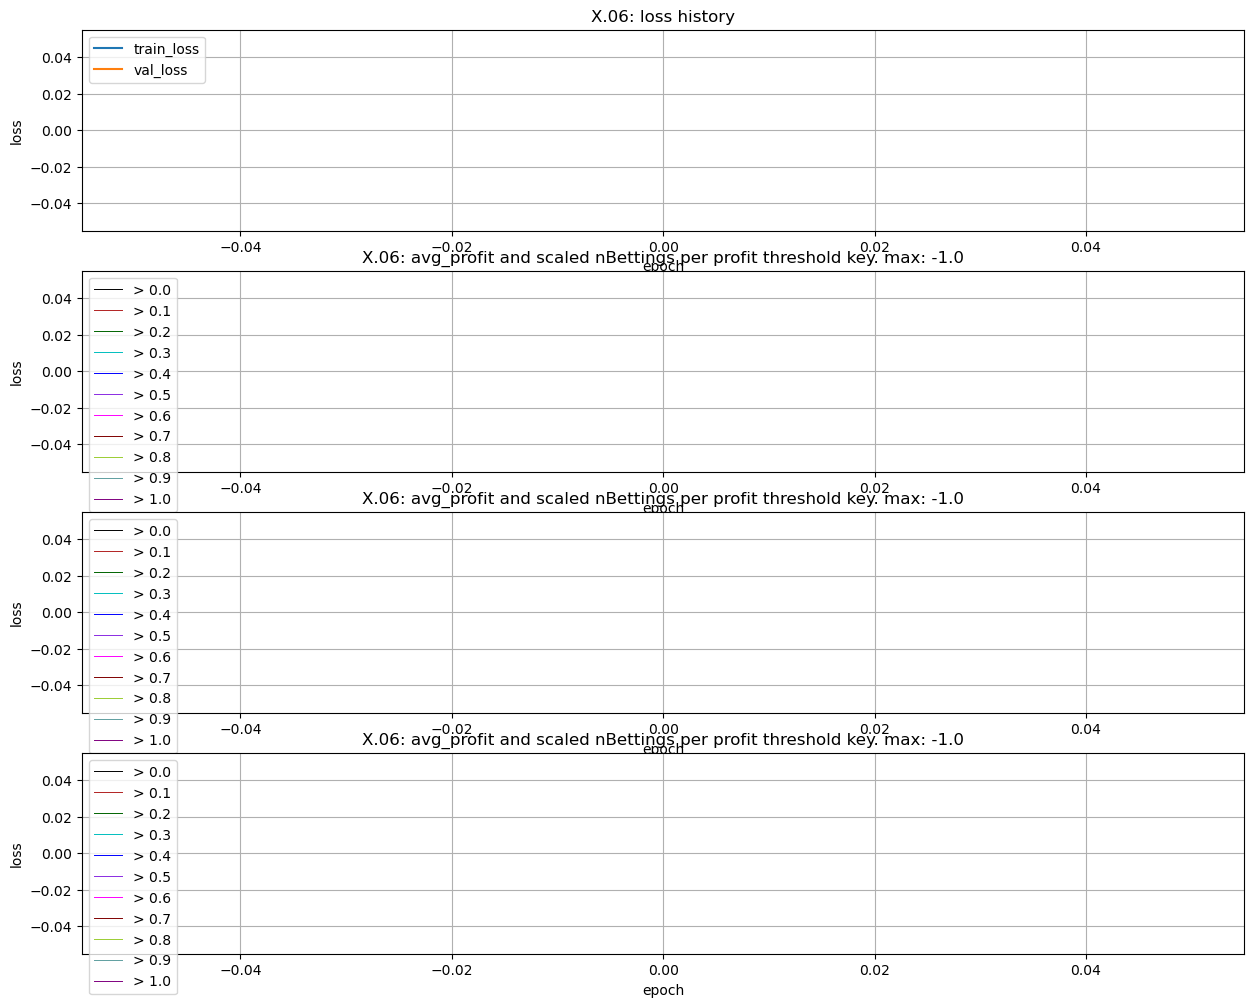

In [52]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,12))
history.show(axes[0]); backtest.show(axes[1]); validtest.show(axes[2]); testtest.show(axes[3]); plt.show()

In [53]:
#-------------------------------------------------------------------------------------------------

profit_series_back, cast_series_back = backtest.find_profit_cast_series()
profit_series_valid, cast_series_valid = validtest.find_profit_cast_series()
profit_series_test, cast_series_test = testtest.find_profit_cast_series()

epoch = 0
for train_loss, val_loss, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test \
    in zip(history.history['loss'], history.history['val_loss'], profit_series_back, cast_series_back, profit_series_valid, cast_series_valid, profit_series_test, cast_series_test):
    print_test(epoch, train_loss, val_loss, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test)
    epoch += 1

In [ ]:
epochs = 500
for epoch in range(history.len(), epochs):
    start_time = time.time()
    history.show(axes[0]); backtest.show(axes[1]); plt.show()
    n = 0; loss = tf.Variable(0.0, dtype=tf.float32); samples_seen = 0
    m = 0; train_loss = 0.0
    
    train_batches = make_train_batches(train_ds)
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (base_label, seq_len_org)) in enumerate(train_batches):
        x = (sequence, base_bb, baseDateDetails, mask); y = base_label
        batch_loss = train_step(x, y)
        n += 1; loss = loss * (n-1)/n + batch_loss/n
        m += 1; train_loss = train_loss * (m-1)/m + batch_loss/m

        samples_seen += sequence.shape[0]
        if step % 50 == 0:
            show_steps(epoch, step, loss, samples_seen)
            n = 0; loss = 0.0

    show_steps(epoch, step, loss, samples_seen)
    conclude_train_epoch(epoch, train_loss)

    print("time taken: {:.1f}m                    ".format((time.time()-start_time)/60))


epoch: 0, loss: 0.07633864879608154, val_loss: 0.0698649063706398, profit: [-0.07286368930377093, -0.10515670859167585, -0.105728436113205, -0.06996109054174299, -0.009745283673206932, -0.0013272096713383994, 0.015803835992738047, -0.0052382730302356455, 0.019747431576251983, 0.08595523458940012, 0.2043970592997291], casts: [1664, 800, 465, 306, 216, 165, 127, 105, 80, 54, 44]
[1.17895, 0.0327, 36, 0.6-0.7], [-0.56597, -0.0098, 58, 0.6-0.8], [-1.74491, -0.0793, 22, 0.7-0.8], [-1.88146, -0.1045, 18, 0.8-0.9], [-2.44742, -0.0322, 76, 0.6-0.9], [-3.62637, -0.0907, 40, 0.7-0.9], [-4.61124, -0.5764, 8, 0.9-1.0], [-5.12629, -0.0540, 95, 0.5-0.7], [-5.13502, -0.0285, 180, 0.2-0.3], [-6.30524, -0.1069, 59, 0.5-0.6], 
[8.99347, 0.2044, 44, 1.0-], [4.64158, 0.0860, 54, 0.9-], [2.55711, 0.1162, 22, 0.6-0.7], [2.00709, 0.0158, 127, 0.6-], [1.57979, 0.0197, 80, 0.8-], [0.42729, 0.0091, 47, 0.6-0.8], [0.33103, 0.0055, 60, 0.5-0.7], [-0.21899, -0.0013, 165, 0.5-], [-0.55002, -0.0052, 105, 0.7-], [-1.